## Customer Segmentation with Unsupervised Learning - Known Customers

In [1]:
import pandas as pd
import numpy as np
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, Binarizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold

In [3]:
!pip3 install imblearn
from imblearn.over_sampling import ADASYN, SMOTE

In [5]:
!pwd

/home/cdsw/01_ML_Project_Basics


In [6]:
df = pd.read_csv('../data/data.csv')

### So far we put all customers in one bucket... 

### But customers behave and spend differently...

In [7]:
df

,name,street_address,city,postcode,phone_number,job,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion,score
0,Shane Davis,650 Reyes Square,New Brad,9930,486.414.3551x5061,Financial trader,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0,0.678715
1,Thomas Fuentes,15482 Anderson Square,Lake Linda,59437,489-096-2389x743,Chiropractor,6,329.08,1,1,Rural,1,Web,No Offer,0,0.961538
2,Sarah Tucker,0709 Maria Drive,New Melissaside,63241,(832)022-5573x275,"Programmer, multimedia",7,180.65,0,1,Surburban,1,Web,Buy One Get One,0,0.205998
3,Greg Nguyen,330 Jason Square,Kendraville,73418,557-122-4652x76680,Youth worker,9,675.83,1,0,Rural,1,Web,Discount,0,1.216920
4,Mrs. Amy Gray,1384 Hall Manor Suite 170,Stevensland,51007,001-623-997-5852x71616,Land/geomatics surveyor,2,45.34,1,0,Urban,0,Web,Buy One Get One,0,1.389221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,Daniel Robles,42981 Bass Locks,Turnerfurt,28905,001-122-661-3301x366,Ambulance person,10,105.54,1,0,Urban,0,Web,Discount,0,1.011057
63996,Amanda Brown,58179 Jennifer Circles,Whitetown,38896,482-237-2940x236,Careers adviser,5,38.91,0,1,Urban,1,Phone,Discount,0,0.884910
63997,Michelle Frost,6009 Ford Island,Port Leonard,43293,001-950-520-9754,Music therapist,6,29.99,1,0,Urban,1,Phone,Discount,0,1.601580
63998,Lisa Avila,89102 Strickland Ports Apt. 911,Lynchborough,20440,+1-026-067-9202x1069,Dancer,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0,1.245146


### Manual Segmentation 

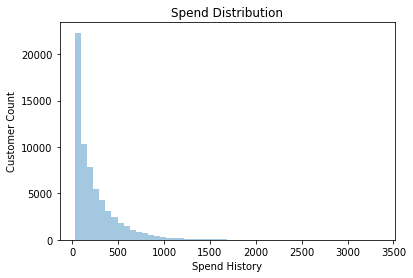

In [8]:
ax = sns.distplot(df.history, kde=False)
ax.set(title='Spend Distribution', xlabel='Spend History', ylabel='Customer Count')
plt.show()

#### Manual Segmentation with Buckets

In [9]:
pd.cut(df['history'], 3, retbins=True)

(0        (26.674, 1135.303]
 1        (26.674, 1135.303]
 2        (26.674, 1135.303]
 3        (26.674, 1135.303]
 4        (26.674, 1135.303]
                 ...        
 63995    (26.674, 1135.303]
 63996    (26.674, 1135.303]
 63997    (26.674, 1135.303]
 63998    (26.674, 1135.303]
 63999    (26.674, 1135.303]
 Name: history, Length: 64000, dtype: category
 Categories (3, interval[float64]): [(26.674, 1135.303] < (1135.303, 2240.617] < (2240.617, 3345.93]],
 array([  26.67406   , 1135.30333333, 2240.61666667, 3345.93      ]))

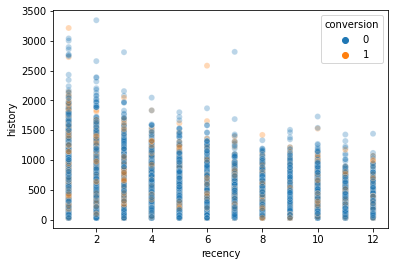

In [10]:
#cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
ax = sns.scatterplot(x="recency", y="history",
                     hue="conversion", alpha=0.3,
                     sizes=(10, 200),
                     data=df)
plt.show()

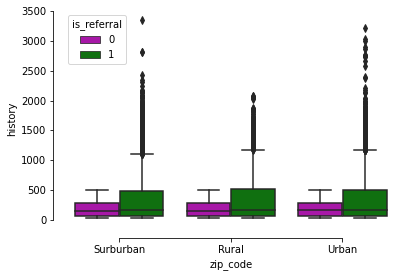

In [11]:
# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="zip_code", y="history",
            hue="is_referral", palette=["m", "g"],
            data=df)
sns.despine(offset=10, trim=True)
plt.show()

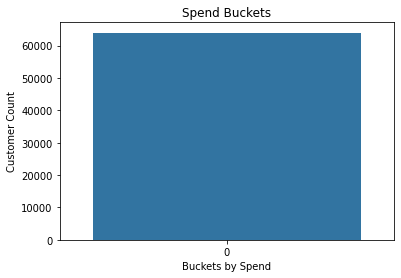

In [12]:
ax = sns.countplot(pd.cut(df['history'], 10, labels=False))
ax.set(title='Spend Buckets', xlabel='Buckets by Spend', ylabel='Customer Count')
plt.show()

### We could now target our customers with different messages based on which bucket they are in... 

### But customer behavior within the above buckets can be radically different

### Machine Learning can help us detect hidden commonalities among customers for better Segmentation

Selecting Features for Unsupervised Learning

In [13]:
df_segm = df[['recency', 'history', 'used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel', 'offer']]

Creating the Unsupervised Learning Model

In [14]:
def processing_pipeline(numeric_features, categorical_features, classifier):

    #numeric_features and categorical_features must be lists

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
    #binary_transformer = Pipeline(steps=[
    #    ('imputer', SimpleImputer(strategy='most_frequent')),
    #    ('binary', Binarizer(threshold=0.5))])
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    #    ('bin', binary_transformer, bin_features)
    ])
    
    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('clf', classifier)])

    return pipe

In [15]:
numeric_features = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral']
categorical_features = ['zip_code', 'channel', 'offer']

In [16]:
from sklearn.cluster import KMeans

In [17]:
kmeans = KMeans(n_clusters=3, random_state=0)

In [18]:
kmeans_pipeline = processing_pipeline(numeric_features, categorical_features, kmeans)

In [19]:
kmeans = kmeans_pipeline.fit(df_segm)

In [20]:
df_segm['cluster'] = kmeans_pipeline.predict(df_segm)

In [21]:
from yellowbrick.cluster import silhouette_visualizer

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


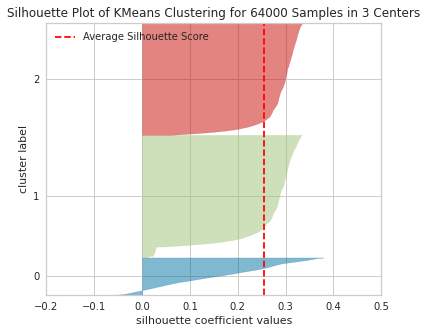

In [22]:
fig, ax = plt.subplots(figsize=(6,5))
ax = silhouette_visualizer(kmeans['clf'], kmeans_pipeline['preprocessor'].transform(df_segm), colors='yellowbrick')
plt.show()

In [23]:
#kmeans['clf'].labels_

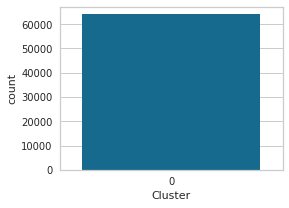

In [24]:
fig, ax = plt.subplots(figsize=(4,3))
ax = sns.countplot(pd.Series(kmeans['clf'].labels_))
ax.set_xlabel('Cluster')
plt.show()

In [25]:
df_segm

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,cluster
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,1
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,2
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,1
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,1
63996,5,38.91,0,1,Urban,1,Phone,Discount,2
63997,6,29.99,1,0,Urban,1,Phone,Discount,1
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


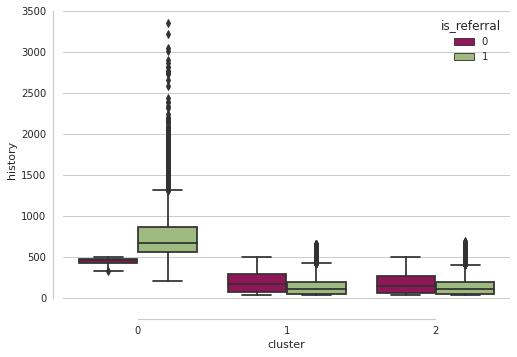

In [26]:
# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="cluster", y="history",
            hue="is_referral", palette=["m", "g"],
            data=df_segm)
sns.despine(offset=10, trim=True)
plt.show()

#### Writing Segments to Datawarehouse

In [27]:
spark = SparkSession\
    .builder\
    .appName("Segments")\
    .config("spark.hadoop.fs.s3a.s3guard.ddb.region","us-east-1")\
    .config("spark.yarn.access.hadoopFileSystems","s3a://demo-aws-2/")\
    .getOrCreate()

NameError: name 'SparkSession' is not defined

In [ ]:
spark_df = spark.createDataFrame(df_segm)

In [ ]:
spark_df\
  .write.format("parquet")\
  .mode("overwrite")\
  .saveAsTable(
    'default.customer_segments'
)